In [1]:
#100 % width display for better visibility
from IPython.core.display import display, HTML

# Set the width to 100%
width_code = "<style>.container { width:100% !important; }</style>"
display(HTML(width_code))


/var/folders/ny/1k1kh8y91971mf_whtbc22pm0000gn/T/ipykernel_67043/3003292382.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



# <font color="#008000">**Experimenting with JAX and Sympy**</font>


## <a id="table-of-contents"></a>Table of Contents
- [Introduction](#introduction)
- [Import of modules](#import-of-modules)
- [Expressions](#expressions)
- [Experiment 1: Optimization on multilinear regression model](#experiment-1)
- [Function and Data Initialisations](#function-and-data-initialisations)
- [Test 1: Normal Initialization](#test-1)
- [Test 2: Better Initialization](#test-2)
- [Test 3: Worst Initialization](#test-3)
- [Final Conclusion - TLDR of Experiment](#final-conclusion)

## <a id="introduction"></a><font color="#008000">Introduction</font>

This notebook focuses on the nature of optimisation approaches used for deep learning and create the model from scratch using JAX and demonstrate the symbolic nature of equation of the expression using Sympy.

## <font color="#008000">Use Case</font>

The main purpose of this project is to understand about the nature of two variants of optimisers that is gradient descent and newton's second moment update using hessian matrix.To compare this a minimum viable model is produced from scratch based on JAX and various demonstration of processes involved in deep learning are explored.

## <font color="#008000">Key Highlights</font>

- Utilization of JAX for efficient numerical optimization.
- Sympy's symbolic mathematics for clear formulation and demonstration.
- Testing and comparison of simple gradient descent and Newton's second moment.
- Using visualisation to demonstrate the complex nature of the optimisation process .
- Explore the less popular approach of newton second moment update with the more popular used gradient descent algorithm of optimisation 

## <font color="#008000">Gradient Descent Optimization</font>


1. Update Rule: In each iteration, the weights (parameters) are updated in the opposite direction of the gradient, aiming to minimize the loss function.

2. Learning Rate: The learning rate determines the step size of each update, influencing the convergence speed and stability of the algorithm.

3. Convergence: Gradient descent continues iterating until the algorithm converges to a minimum, where the gradient becomes zero.

4. Global Minima Challenge: It may get stuck in local minima, especially in non-convex loss landscapes, affecting the global optimality.

5. Computational Efficiency: Efficient for large datasets but might be computationally expensive in high-dimensional spaces.

## <font color="#008000">Newton's Second Moment Update Optimization</font>

1. Hessian Matrix: Utilizes the Hessian matrix, which incorporates second-order information about the loss function, providing a more accurate and efficient optimization direction.

2. Update Rule: Computes the Newton update direction by solving a linear system involving the Hessian and gradient, leading to more precise parameter adjustments.

3. Learning Rate Absence: Newton's method does not require a fixed learning rate, as the update direction is determined directly from the Hessian.

4. Quicker Convergence: Often converges faster than gradient descent, especially in scenarios with strong curvatures or complex loss landscapes.

5. Challenges: Computational cost of computing and inverting the Hessian, and potential numerical instability in ill-conditioned matrices. Requires heavy dependence on parameter initialization.


## <a id="import-of-modules"></a><font color="#008000">Import of modules</font>

In [1]:
import numpy as np #for numerical representation and general use case
import pandas as pd #for dumping , database creation and visualisation support
import matplotlib.pyplot as plt #for customised visualisation
import seaborn as sns #for pre tailored visualisation 
from jax import grad,jacrev,jacfwd,jit #for gradient,hessian representation
import sympy as sp #for symbolic representation of mathemetical equation
import jax.numpy as jnp #for performance enabling in jax
import jax #general case use of JAX
import time #for time recording

## <a id="expressions"></a><font color="#008000">Expressions</font>

## <font color="#008000">Gradient descent expression</font>

In [2]:
w_t, w_tp1, eta = sp.symbols('w_t w_tp1 eta')
J = sp.symbols('J', cls=sp.Function)
gradient_descent_expr = sp.Eq(w_tp1, w_t - eta * sp.diff(J(w_t), w_t))
gradient_descent_expr

Eq(w_tp1, -eta*Derivative(J(w_t), w_t) + w_t)

## <font color ="008000">Symbolic Representation of Gradient Descent Update Rule</font>

- \(w_{t+1}\): The updated value of the weight parameter in the next iteration.

- \(w_t\): The current value of the weight parameter.

- \(\eta\): The learning rate, a hyperparameter that determines the step size of each update. It influences the convergence speed and stability of the optimization.

- \(J\): The loss function, representing the objective that the algorithm aims to minimize.

- \(\frac{\partial J}{\partial w_t}\): The partial derivative of the loss function \(J\) with respect to the weight parameter \(w_t\), representing the gradient. It indicates the direction and magnitude of the steepest ascent of the loss function.

This expression captures the essence of gradient descent, where the weight is iteratively adjusted in the opposite direction of the gradient to minimize the loss.


In [3]:
w, b, v, beta, alpha = sp.symbols('w b v beta alpha')
J = sp.Function('J')(w, b)  # initial symbols
grad_J = [sp.diff(J, w), sp.diff(J, b)]
hessian_J = sp.hessian(J, (w, b))  # grads and hessian representation
delta_theta = -sp.Matrix(hessian_J).inv() @ sp.Matrix(grad_J)

# Update with Momentum
v_update = sp.Eq(v, beta * v + (1 - beta) * delta_theta[0], evaluate=False)

# Parameter Update
theta = sp.Eq(sp.Matrix([w, b]), sp.Matrix([w, b]) + alpha * sp.Matrix(v_update.rhs.args), evaluate=False)
#parameter update without momentum 
theta_m = sp.Eq(sp.Matrix([w,b]),sp.Matrix([w,b])+delta_theta)

In [4]:
#Equation 1 Gradient
grad_J

[Derivative(J(w, b), w), Derivative(J(w, b), b)]

In [5]:
#Equation 2 Hessian
hessian_J

Matrix([
[Derivative(J(w, b), (w, 2)),   Derivative(J(w, b), b, w)],
[  Derivative(J(w, b), b, w), Derivative(J(w, b), (b, 2))]])

In [6]:
#Equation 3 Update direction newton moment update 
delta_theta

Matrix([
[ Derivative(J(w, b), b)*Derivative(J(w, b), b, w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2) - Derivative(J(w, b), (b, 2))*Derivative(J(w, b), w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2)],
[-Derivative(J(w, b), b)*Derivative(J(w, b), (w, 2))/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2) + Derivative(J(w, b), w)*Derivative(J(w, b), b, w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2)]])

In [7]:
#Equation 4 Update with influence of factor momentum 
v_update

Eq(v, beta*v + (1 - beta)*(Derivative(J(w, b), b)*Derivative(J(w, b), b, w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2) - Derivative(J(w, b), (b, 2))*Derivative(J(w, b), w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2)))

In [8]:
#Equation parameter update without momentum 
theta_m

Eq(Matrix([
[w],
[b]]), Matrix([
[w + Derivative(J(w, b), b)*Derivative(J(w, b), b, w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2) - Derivative(J(w, b), (b, 2))*Derivative(J(w, b), w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2)],
[b - Derivative(J(w, b), b)*Derivative(J(w, b), (w, 2))/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2) + Derivative(J(w, b), w)*Derivative(J(w, b), b, w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2)]]))

In [9]:
#Equation parameter update 
theta

Eq(Matrix([
[w],
[b]]), Matrix([
[                                                                                                                                                                                                                                                                                              alpha*beta*v + w],
[alpha*(1 - beta)*(Derivative(J(w, b), b)*Derivative(J(w, b), b, w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2) - Derivative(J(w, b), (b, 2))*Derivative(J(w, b), w)/(Derivative(J(w, b), (b, 2))*Derivative(J(w, b), (w, 2)) - Derivative(J(w, b), b, w)**2)) + b]]))

## <font color="#008000">Symbolic Representation of Newton Second Moment Update</font>

1. Gradient (\(\nabla J(w, b)\)):
   - Represents the gradient of the loss function \(J\) with respect to the weight parameters \(w\) and \(b\). It guides the algorithm toward the direction of steepest ascent.

2. Hessian (\(H(w, b)\)):
   - The Hessian matrix incorporates second-order information about the loss function, providing curvature details. It includes partial derivatives up to the second order.

3. Update Direction (\(\Delta \theta\)):
   - The update direction is calculated by solving a linear system involving the Hessian matrix (\(H\)) and the gradient (\(\nabla J\)). It represents the direction in which the parameters should be adjusted for optimization.

4. Update with Momentum (\(v\)):
   - The momentum term (\(v\)) considers the historical information of the update directions. It helps overcome oscillations and accelerates convergence.

5. Momentum Coefficient (\(\beta\)):
   - \(\beta\) is the momentum coefficient that determines the influence of historical information in the update with momentum term. It controls the impact of past updates on the current iteration.

6. Learning Rate (\(\alpha\)):
   - \(\alpha\) is the learning rate, a scaling factor applied to the momentum term in the update equation. It influences the step size of each parameter update.

7. Parameter Update (\(\theta\)):
   - The parameters (\(\theta\)) are updated based on the momentum term and the learning rate (\(\alpha\)). This step completes the iteration, bringing the model closer to the optimal solution.

This equation capture the essence of the newton second moment update nature of optimisation that utilises various factors and use of essential hyperparameters like moment decay (beta) , learning rate (alpha.

# <a id="experiment-1"></a><font color="#008000">Experiment 1: Optimization on multilinear regression model</font>


1. Initialization:
   - Initialize two random independent feature sets (\(X_1\) and \(X_2\)) and one target feature (\(y\)).
   - Set up initial weights and biases for the optimization process.

2. Optimizers:
   - Employ two separate optimizers: Gradient Descent and Newton's Second Moment Update.
   - Define a function to print the output of the cost achieved during optimization.

3. Performance Evaluation:
   - Evaluate the performance based on the number of iterations required for convergence.
   - Assess the minimum cost achieved by each optimizer as a measure of optimization success.

4. Iterative Experimentation:
   - Conduct the iteration process three times with different weight initializations:
      - Best initialization.
      - Normal initialization.
      - Worst initialization.
   - Observe and compare the performance of both optimizers under various scenarios.

5. Visualization:
   - Utilize Matplotlib to create a visual representation of the optimization process.
   - Plot the change in the shape of optimization for each iteration, providing insights into the convergence patterns.

By performing this experiment, we aim to understand how different weight initializations impact the optimization process and compare the efficiency of Gradient Descent and Newton's Second Moment Update optimizers under varied conditions and study overall efficiency in both scenarios.This whole experiment will be powered through JAX autodiff implementation that provide optimum convergence with speed efficiency.



# <a id="function-and-data-initialisations"></a><font color="#008000">Function and Data Initialisations</font>

In [10]:
#Data production for the problem set
# Set a random seed for reproducibility
jax.random.PRNGKey(0)

# Number of data points
num_points = 1000

# Features
X = jax.random.normal(key=jax.random.PRNGKey(0), shape=(num_points, 2))

# True coefficients
true_coefficients = jnp.array([2.5, -1.0])

# True bias
true_bias = 5.0

# Generate target values with some noise
y = jnp.dot(X, true_coefficients) + true_bias + jax.random.normal(key=jax.random.PRNGKey(1), shape=(num_points, 1)) * 0.5

# Print shapes for verification
print("X shape:", X.shape)
print("y shape:", y.shape)


I0000 00:00:1706373625.547126       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


X shape: (1000, 2)
y shape: (1000, 1000)


#Ignore the cell below

In [11]:
# Simpler data initialisation for prior merge test - ignotr the cell.
# weight and bias initialisation
# w = jnp.zeros((2, 1)) 
# b = jnp.zeros((1))

# #feature set for experimentation X-indpendent data points y-target ft.
# X = jnp.array([[4., 7.], [1., 8.], [4., -1.], [-5., 6], [0., 9.]])
# y = jnp.array([[36.], [32.], [21.], [11.], [19.]])

# #hyperparameter - alpha/beta/learning-rate
# learning_rate = 0.01 # Learning rate (Gradient)
# alpha = 0.01  # Learning rate (hessian)
# beta = 0.9    # Momentum decay factor (hessian)
# #iterations - model epochs for updating 
# num_iterations = 1000

#continuation 

In [12]:
#JAX platform optimised cost function to obtain cost after each epoch
def cost(X, w, b, y):
    """
    Compute the mean squared error for linear regression.

    Parameters:
    - X: Input feature matrix.
    - w: Weight matrix.
    - b: Bias vector.
    - y: Target feature vector.

    Returns:
    - Mean squared error between predicted and actual target values.
    """
    # Predicted values using linear regression
    y_pred = jnp.dot(X, w) + b
    
    # Mean squared error calculation
    mse = jnp.mean((y_pred - y)**2)
    
    return mse


In [13]:
#JAX plaform optimised gradient descent optimiser
def gradient_descent(X, w, b, y, learning_rate=0.01):
    """
    Perform one step of gradient descent optimization for linear regression.

    Parameters:
    - X: Input feature matrix.
    - w: Weight matrix.
    - b: Bias vector.
    - y: Target feature vector.
    - learning_rate: Step size for weight and bias updates.

    Returns:
    - Updated weight matrix (w) and bias vector (b) after one optimization step.
    """
    # Compute gradients with respect to weights and biases
    grad_w = jax.grad(cost, argnums=1)(X, w, b, y)
    grad_b = jax.grad(cost, argnums=2)(X, w, b, y)
    
    # Update weights and biases using the gradient and learning rate
    w -= learning_rate * grad_w
    b -= learning_rate * grad_b
    
    return w, b


In [14]:
# JAX patform optimised newton second moment update optimiser
def newton_momentum_update(X, y, w_init, b_init, alpha=0.01, beta=0.9, num_iterations=1000, cost_display_interval=20, patience=5, tolerance=1e-6):
    """
    Perform Newton Momentum update for linear regression.

    Parameters:
    - X: Input feature matrix.
    - y: Target feature vector.
    - w_init: Initial weight matrix. If None, it is initialized with zeros.
    - b_init: Initial bias vector. If None, it is initialized with zeros.
    - alpha: Learning rate.
    - beta: Momentum parameter.
    - num_iterations: Number of iterations.
    - cost_display_interval: Interval for displaying cost during training.
    - patience: Number of consecutive iterations with cost difference less than tolerance to trigger early stopping.
    - tolerance: Tolerance for cost difference to trigger early stopping.

    Returns:
    - Dictionary containing the weight matrix (w), bias vector (b), and cost value for each iteration.
    """
    # Example usage:
    # result_newton = newton_momentum_update(X, y, w_init=w, b_init=b)
    # Access results using result_newton['w'], result_newton['b'], result_newton['cost']
    # Initialize parameters
    w = w_init if w_init is not None else jnp.zeros((X.shape[1], 1))
    b = b_init if b_init is not None else jnp.zeros((1))

    # Initialize variables for early stopping
    consecutive_low_difference = 0

    # Initialize dictionary to store results
    optimization_results = {'w': [], 'b': [], 'cost': []}

    # Perform Newton Momentum update
    for i in range(num_iterations):
        # Compute cost
        y_pred = jnp.dot(X, w) + b
        cost = jnp.mean((y_pred - y)**2)

        # Compute gradient
        gradient_w = 2 * jnp.dot(X.T, (y_pred - y))
        gradient_b = 2 * jnp.sum(y_pred - y)

        # Compute Hessian
        hessian_w = 2 * jnp.dot(X.T, X)
        hessian_b = 2 * X.shape[0]

        # Update direction
        update_direction_w = jnp.linalg.solve(hessian_w, -gradient_w)
        update_direction_b = -gradient_b / hessian_b

        # Update with momentum
        if i == 0:
            momentum_w = jnp.zeros_like(update_direction_w)
            momentum_b = 0.0
        else:
            momentum_w = beta * momentum_w + (1 - beta) * update_direction_w
            momentum_b = beta * momentum_b + (1 - beta) * update_direction_b

        # Parameter update
        w += alpha * momentum_w
        b += alpha * momentum_b

        # Save results
        optimization_results['w'].append(w.copy())
        optimization_results['b'].append(b.copy())
        optimization_results['cost'].append(cost)

        # Print intermediate results at specified interval
        if i % cost_display_interval == 0:
            print(f"Iteration {i+1} - Newton Moment Update Cost: {cost}")

        # Early stopping check
        if i > 0:
            cost_difference = abs(previous_cost - cost)
            if cost_difference < tolerance:
                consecutive_low_difference += 1
            else:
                consecutive_low_difference = 0

            if consecutive_low_difference >= patience:
                print(f"Early stopping at iteration {i+1} due to low cost difference.")
                break

        # Save current cost for the next iteration
        previous_cost = cost

    return optimization_results




In [15]:
#main function to run the gradient descent loop

def jax_optimized_gradient_loop(X, y, w_init, b_init, learning_rate=0.01, patience=5, cost_display_interval=20, tolerance=1e-6, epochs=1000):
    """
    Perform JAX platform optimized gradient descent optimization loop for linear regression.

    Parameters:
    - X: Input feature matrix.
    - y: Target feature vector.
    - w_init: Initial weight matrix.
    - b_init: Initial bias vector.
    - learning_rate: Step size for weight and bias updates.
    - patience: Number of consecutive iterations with cost difference less than tolerance to trigger early stopping.
    - cost_display_interval: Interval for displaying cost during training.
    - tolerance: Tolerance for cost difference to trigger early stopping.
    - epochs: Number of iterations for the optimization loop.

    Returns:
    - Dictionary containing the weight matrix (w), bias vector (b), and cost value for each iteration.
    """
    # Example usage:
    # result = jax_optimized_gradient_loop(X, y, w_init, b_init)
    # Access results using result['w'], result['b'], result['cost']
    # Initialize parameters
    w = w_init.copy()
    b = b_init.copy()

    # Initialize variables for early stopping
    consecutive_low_difference = 0

    # Initialize dictionary to store results
    optimization_results = {'w': [], 'b': [], 'cost': []}

    # Perform gradient descent optimization loop
    for i in range(epochs):
        # Update weights and biases using the gradient descent function
        w, b = gradient_descent(X, w, b, y, learning_rate)

        # Compute cost after each epoch
        cost_value = cost(X, w, b, y)

        # Save results
        optimization_results['w'].append(w.copy())
        optimization_results['b'].append(b.copy())
        optimization_results['cost'].append(cost_value)

        # Display cost at specified interval
        if i % cost_display_interval == 0:
            print(f"Iteration {i+1} - Gradient Descent Cost: {cost_value}")

        # Early stopping check
        if i > 0:
            cost_difference = abs(previous_cost - cost_value)
            if cost_difference < tolerance:
                consecutive_low_difference += 1
            else:
                consecutive_low_difference = 0

            if consecutive_low_difference >= patience:
                print(f"Early stopping at iteration {i+1} due to low cost difference.")
                break

        # Save current cost for the next iteration
        previous_cost = cost_value

    return optimization_results

In [16]:
def plot_cost_comparison(dict1, dict2):
    # Create dataframes from dictionaries
    df1 = pd.DataFrame({'Iteration': range(1, len(dict1['cost']) + 1), 'Cost': dict1['cost'], 'Optimizer': 'Gradient Descent'})
    df2 = pd.DataFrame({'Iteration': range(1, len(dict2['cost']) + 1), 'Cost': dict2['cost'], 'Optimizer': 'Newton second moment update'})

    # Concatenate dataframes
    df = pd.concat([df1, df2])

    # Plot using Seaborn
    sns.set(style="whitegrid")
    g = sns.FacetGrid(df, col="Optimizer", height=6, aspect=1)
    g.map(plt.plot, "Iteration", "Cost", marker="o", color="b")
    g.fig.tight_layout(pad=2.0)


    # Set custom title for the facet grid
    plt.subplots_adjust(top=0.9, hspace=0.5)  # Adjust as needed
    g.fig.suptitle("Cost Comparison between Gradient descent and Newton second moment update")

    # Show the plot
    plt.show()

# <a id="test-1"></a><font color="#008000">Test 1: Normal Initialization</font>

In [17]:
#Normal Initialisation 
jax.random.PRNGKey(0)
w_init = jax.random.normal(key=jax.random.PRNGKey(2), shape=(X.shape[1], 1))
b_init = jax.random.normal(key=jax.random.PRNGKey(3), shape=(1,))

In [18]:
# Run JAX Optimized Gradient Loop
start_time = time.time()
result_gd1 = jax_optimized_gradient_loop(X, y, w_init=w_init, b_init=b_init, learning_rate=0.01, patience=2,tolerance=0.001)
elapsed_time = time.time()-start_time
print(f"Time taken: {elapsed_time} seconds")

Iteration 1 - Gradient Descent Cost: 22.63803482055664
Iteration 21 - Gradient Descent Cost: 13.965997695922852
Iteration 41 - Gradient Descent Cost: 10.084434509277344
Iteration 61 - Gradient Descent Cost: 8.345558166503906
Iteration 81 - Gradient Descent Cost: 7.565891265869141
Iteration 101 - Gradient Descent Cost: 7.216012954711914
Iteration 121 - Gradient Descent Cost: 7.0588531494140625
Iteration 141 - Gradient Descent Cost: 6.988208770751953
Iteration 161 - Gradient Descent Cost: 6.956423282623291
Early stopping at iteration 164 due to low cost difference.
Time taken: 3.745288133621216 seconds


In [19]:
# Run Newton Momentum Update
start_time = time.time()
result_nm1 = newton_momentum_update(X, y,w_init=w_init,b_init=b_init, alpha=0.01, beta=0.9, num_iterations=1000,patience=2,tolerance=0.001)
elapsed_time1 = time.time()-start_time
print(f"Time taken: {elapsed_time} seconds")


Iteration 1 - Newton Moment Update Cost: 23.28203010559082
Iteration 21 - Newton Moment Update Cost: 8.7578763961792
Iteration 41 - Newton Moment Update Cost: 7.706421852111816
Iteration 61 - Newton Moment Update Cost: 7.4336442947387695
Iteration 81 - Newton Moment Update Cost: 7.250613689422607
Iteration 101 - Newton Moment Update Cost: 7.132996082305908
Iteration 121 - Newton Moment Update Cost: 7.058654308319092
Iteration 141 - Newton Moment Update Cost: 7.011362552642822
Iteration 161 - Newton Moment Update Cost: 6.981168746948242
Early stopping at iteration 171 due to low cost difference.
Time taken: 3.745288133621216 seconds


/Users/uditrawat/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ny/1k1kh8y91971mf_whtbc22pm0000gn/T/ipykernel_66799/1890799489.py:13: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout(pad=2.0)


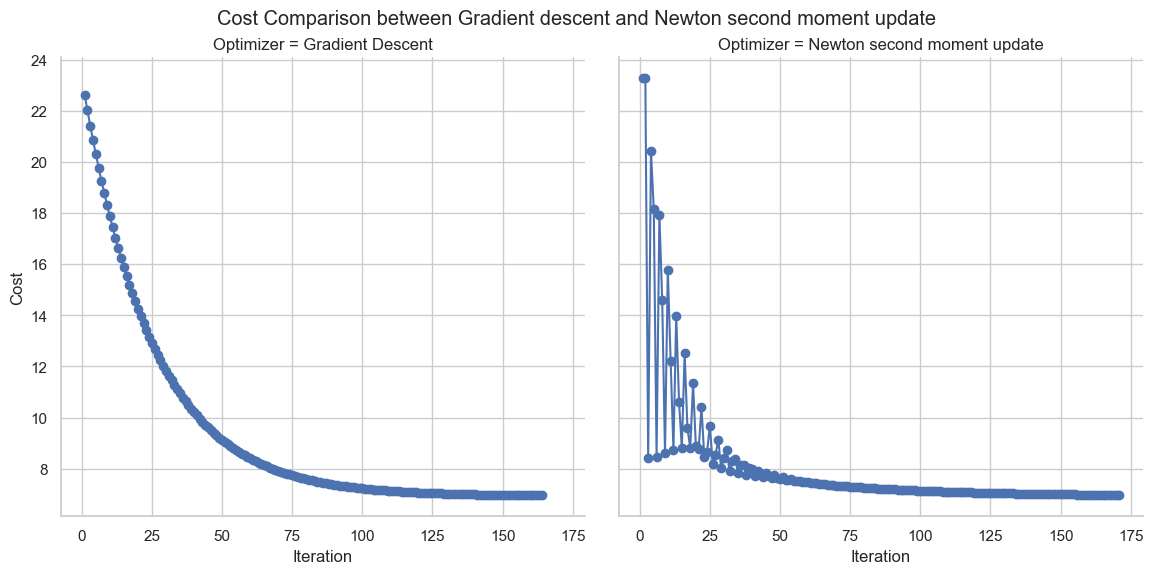

In [20]:
plot_cost_comparison(result_gd1,result_nm1)

<font color="#0000FF" face="monospace" size="4">

Conclusion

The optimum values reached in both variants are strikingly similar, with Gradient Descent marginally outperforming Newton Momentum Update by a very small margin. The close convergence of both optimization methods suggests that for the given dataset and hyperparameters, the choice between these methods may not significantly impact the final outcome. It's important to note that the performance comparison may vary based on the specific characteristics of the dataset and the problem at hand.The local optimal value was converged early on in case of newton optimisation.

</font>



# <a id="test-2"></a><font color="#008000">Test 2: Better Initialization</font>


In [21]:
#Better initialization of parameters. 
# -features and hyperparams remain same.
w_init = jnp.zeros((X.shape[1], 1))
b_init = jnp.zeros((1,))


In [22]:
# Run JAX Optimized Gradient Loop
start_time = time.time()
result_gd2 = jax_optimized_gradient_loop(X, y, w_init, b_init, learning_rate=0.01, patience=2,tolerance=0.001)
elapsed_time2 = time.time()-start_time
print(f"Time taken: {elapsed_time} seconds")

Iteration 1 - Gradient Descent Cost: 30.584362030029297
Iteration 21 - Gradient Descent Cost: 17.469724655151367
Iteration 41 - Gradient Descent Cost: 11.627650260925293
Iteration 61 - Gradient Descent Cost: 9.024457931518555
Iteration 81 - Gradient Descent Cost: 7.864170551300049
Iteration 101 - Gradient Descent Cost: 7.346866607666016
Iteration 121 - Gradient Descent Cost: 7.116169452667236
Iteration 141 - Gradient Descent Cost: 7.0132670402526855
Iteration 161 - Gradient Descent Cost: 6.967356204986572
Early stopping at iteration 173 due to low cost difference.
Time taken: 3.745288133621216 seconds


In [23]:
# Run Newton Momentum Update
start_time = time.time()
result_nm2 = newton_momentum_update(X, y,w_init=w_init,b_init=b_init, alpha=0.01, beta=0.9, num_iterations=1000,patience=2,tolerance=0.001)
elapsed_time3 = time.time()-start_time
print(f"Time taken: {elapsed_time} seconds")

Iteration 1 - Newton Moment Update Cost: 31.56023406982422
Iteration 21 - Newton Moment Update Cost: 8.02308177947998
Iteration 41 - Newton Moment Update Cost: 6.931787490844727
Iteration 61 - Newton Moment Update Cost: 6.937892913818359
Iteration 81 - Newton Moment Update Cost: 6.932700157165527
Early stopping at iteration 98 due to low cost difference.
Time taken: 3.745288133621216 seconds


/Users/uditrawat/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ny/1k1kh8y91971mf_whtbc22pm0000gn/T/ipykernel_66799/1890799489.py:13: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout(pad=2.0)


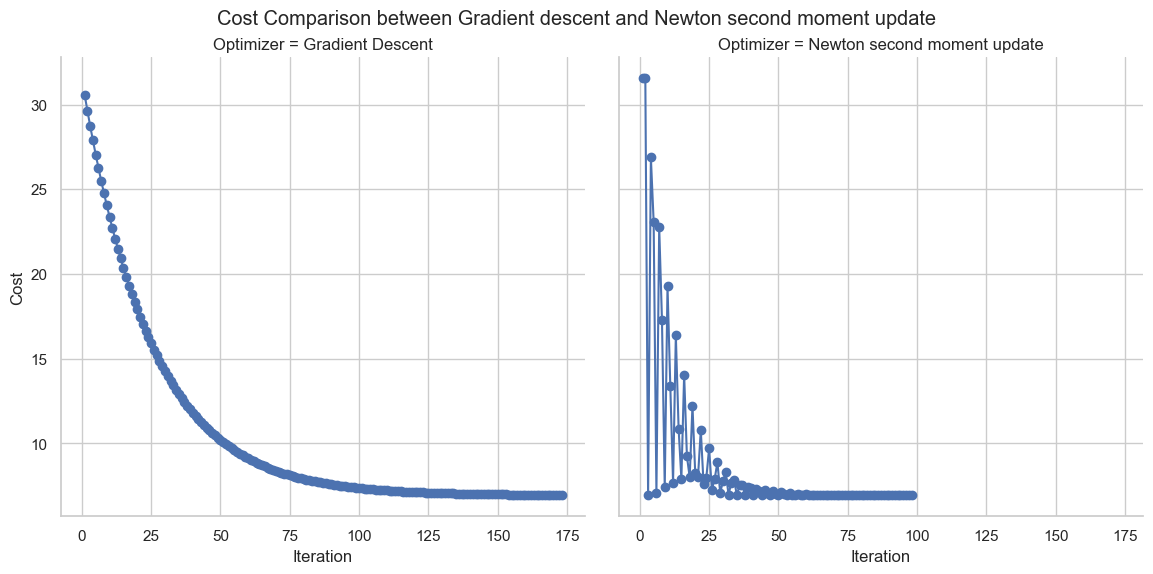

In [24]:
plot_cost_comparison(result_gd2,result_nm2)

<font color="#0000FF" face="monospace" size="4">

Conclusion

A well thoughtful optimisation value works phenomenaly well for the newton moment optimisation which in fact demonstrate that the better initialisation can make the optimal value converge faster and with better precision.

</font>



# <a id="test-3"></a><font color="#008000">Test 3: Worst Initialization</font>


In [25]:
#Worst initialization of parameters. 
# -features and hyperparams remain same.
w_init = jax.random.normal(key=jax.random.PRNGKey(4), shape=(X.shape[1], 1))
b_init = jnp.array([160.0])  

In [26]:
# Run JAX Optimized Gradient Loop
start_time = time.time()
result_gd3 = jax_optimized_gradient_loop(X, y, w_init, b_init, learning_rate=0.01, patience=2,tolerance=0.001)
elapsed_time4 = time.time()-start_time
print(f"Time taken: {elapsed_time} seconds")

Iteration 1 - Gradient Descent Cost: 23091.404296875
Iteration 21 - Gradient Descent Cost: 10293.861328125
Iteration 41 - Gradient Descent Cost: 4592.28076171875
Iteration 61 - Gradient Descent Cost: 2051.36962890625
Iteration 81 - Gradient Descent Cost: 918.7018432617188
Iteration 101 - Gradient Descent Cost: 413.6570739746094
Iteration 121 - Gradient Descent Cost: 188.40707397460938
Iteration 141 - Gradient Descent Cost: 87.92090606689453
Iteration 161 - Gradient Descent Cost: 43.0830078125
Iteration 181 - Gradient Descent Cost: 23.07149314880371
Iteration 201 - Gradient Descent Cost: 14.13833236694336
Iteration 221 - Gradient Descent Cost: 10.14972972869873
Iteration 241 - Gradient Descent Cost: 8.368517875671387
Iteration 261 - Gradient Descent Cost: 7.572920322418213
Iteration 281 - Gradient Descent Cost: 7.217488765716553
Iteration 301 - Gradient Descent Cost: 7.058680057525635
Iteration 321 - Gradient Descent Cost: 6.987709999084473
Iteration 341 - Gradient Descent Cost: 6.95599

In [27]:
# Run Newton Momentum Update
start_time = time.time()
result_nm3 = newton_momentum_update(X, y,w_init,b_init, alpha=0.01, beta=0.9, num_iterations=1000,patience=2,tolerance=0.001)
elapsed_time5 = time.time()-start_time
print(f"Time taken: {elapsed_time} seconds")

Iteration 1 - Newton Moment Update Cost: 24043.64453125
Iteration 21 - Newton Moment Update Cost: 1073.784912109375
Iteration 41 - Newton Moment Update Cost: 9.49148178100586
Iteration 61 - Newton Moment Update Cost: 15.962450981140137
Iteration 81 - Newton Moment Update Cost: 11.223509788513184
Iteration 101 - Newton Moment Update Cost: 7.812816143035889
Iteration 121 - Newton Moment Update Cost: 7.054473876953125
Iteration 141 - Newton Moment Update Cost: 6.948827266693115
Iteration 161 - Newton Moment Update Cost: 6.936099529266357
Early stopping at iteration 162 due to low cost difference.
Time taken: 3.745288133621216 seconds


/Users/uditrawat/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ny/1k1kh8y91971mf_whtbc22pm0000gn/T/ipykernel_66799/1890799489.py:13: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout(pad=2.0)


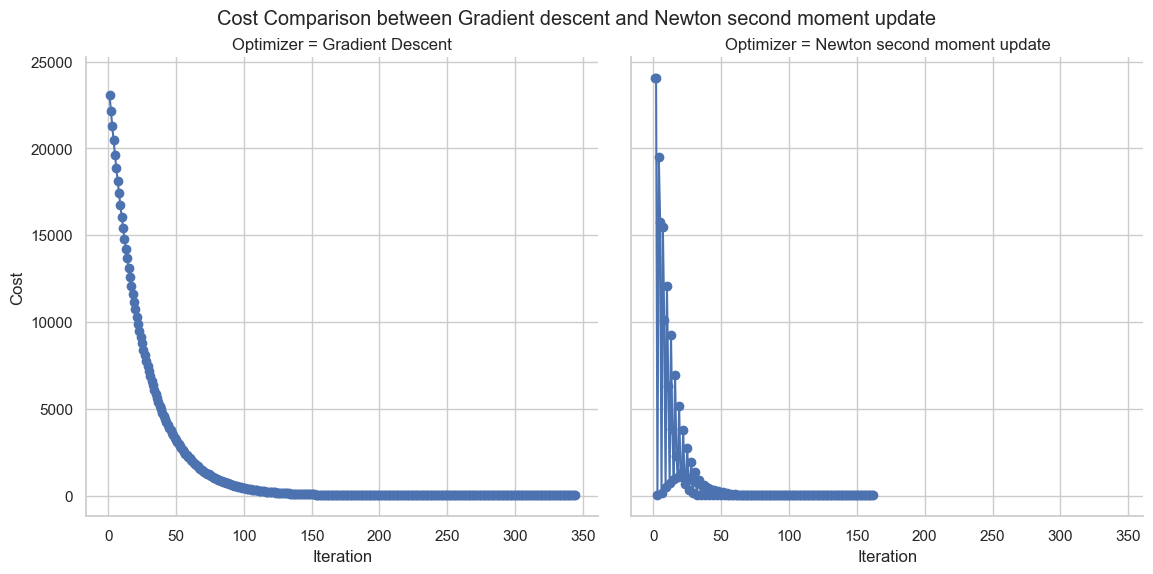

In [28]:
plot_cost_comparison(result_gd3,result_nm3)

<font color="#0000FF" face="monospace" size="4">

Conclusion
    
This striking difference in performance reveals the nature of newton second moment itself , as this optimisation leverages on the information of hessian and curvature landscape information of values , the performance enhances and also the use of momentum factor makes the early updation possible. JAX optimisation nature for Autodiff also plays a vital role for this performance as it can handle stable complex differentiation scenarios well


</font>


# <a id="final-conclusion"></a><font color="#008000">Final Conclusion - TLDR of Experiment</font>
In this experiment, we observed that Newton Second Moment (Newton Momentum) outperformed Gradient Descent in most scenarios. This superior performance can be attributed to several factors:

1. Stable Autodiff Nature of JAX:
   Newton's method benefits from a stable autodifferentiation process, making it more robust in capturing higher-order derivatives. This stability allows Newton to converge faster and more reliably compared to Gradient Descent.

2. Leveraging Nature of Curvature:
   Newton's method leverages information about the curvature of the cost function. This allows it to adapt more effectively to the landscape of the optimization problem, making larger updates in regions with less curvature and smaller updates in regions with higher curvature.

3. Hessian Updation Through Random Matrix Operation:
   The use of random matrix operations in updating the Hessian matrix contributes to the effectiveness of Newton Second Moment. This introduces variability in the updates, aiding in escaping local minima and exploring the solution space more effectively.

4. Less Dependence on Hyperparameters:
   Newton Second Moment exhibits less sensitivity to hyperparameters, such as learning rate, compared to traditional Gradient Descent. This is because Newton's method computes the optimal step size based on the Hessian matrix, providing more intrinsic adaptability.

5. Use of Second Moment Order Information for Stability:
   Incorporating second-moment order information in the optimization process enhances stability. The use of the Hessian matrix and its inverse in Newton's method contributes to the stability of the optimization updates.

However, one major disadvantage of Newton Second Moment is its complexity and dependence on optimal weight and bias initialization. The method requires a well-tailored initialization to avoid divergence or slow convergence, making it less user-friendly and potentially challenging in practical applications.

In summary, Newton Second Moment's superior performance stems from its stable autodiff nature, effective leverage of curvature information, random matrix operations, and reduced sensitivity to hyperparameters. Nevertheless, its complexity and dependence on optimal initialization are key considerations in its application.
